In [1]:
import os
import nltk
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Embedding, Dropout, BatchNormalization, Input, Add, Concatenate,\
    Bidirectional, SimpleRNN, LSTM, GRU
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation


stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

Using TensorFlow backend.


In [1]:
!pip3 install -q gensim==3.2.0

## Data Loader

In [2]:
def load_data(file_name):
    
    df = pd.read_csv(file_name)

    return df["review_id"], df["text"], df["stars"]

def write_predictions(file_name, pred, text):
    d = {'review_id': text, 'stars': pred}
    df = pd.DataFrame(d)
    df.to_csv(file_name, index=False)

## Feature Extractor

- Token, Stemming, Stopwords, Punctuation

In [3]:
def tokenize(text):
    
    return nltk.word_tokenize(text)

def stem(tokens):
    
    return [ps.stem(token).lower() for token in tokens]

def filter_stopwords(tokens):

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

def remove_punc(tokens):
    
    return ''.join([token.lower() for token in tokens if token not in punctuation])

In [4]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = ["<pad>", "<unk>"] + [f for f, cnt in feat_cnt.most_common(max_size-2)]
    else:
        valid_feats = ["<pad>", "<unk>"]
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

## Classifier: RNN

In [5]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,                        
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),    ## He initializer
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),      ## He initializer
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

## Tryout_1, Self-trained Word2Vec Embedding

In [6]:
train_file = "data/train.csv"
valid_file = "data/valid.csv"
test_file = "data/test.csv"

# load data
train_ids, train_texts, train_labels = load_data(train_file)
valid_ids, valid_texts, valid_labels = load_data(valid_file)
test_ids, test_texts, test_labels = load_data(test_file)

In [30]:
# extract features
train_no_punc = [remove_punc(text) for text in train_texts]
valid_no_punc = [remove_punc(text) for text in valid_texts]
test_no_punc = [remove_punc(text) for text in test_texts]

In [31]:
train_tokens = [tokenize(text) for text in train_no_punc]
valid_tokens = [tokenize(text) for text in valid_no_punc]
test_tokens = [tokenize(text) for text in test_no_punc]

train_stop = [filter_stopwords(tokens) for tokens in train_tokens]
valid_stop = [filter_stopwords(tokens) for tokens in valid_tokens]
test_stop = [filter_stopwords(tokens) for tokens in test_tokens]

train_stemmed = [stem(tokens) for tokens in train_stop]
valid_stemmed = [stem(tokens) for tokens in valid_stop]
test_stemmed = [stem(tokens) for tokens in test_stop]

In [32]:
train_feats = train_stemmed
valid_feats = valid_stemmed
test_feats = test_stemmed

In [33]:
min_freq = 3
# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=min_freq)

Size of features: 11996


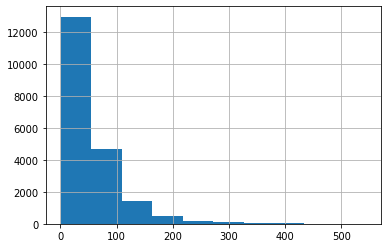

count    20000.000000
mean        56.599950
std         52.410665
min          1.000000
25%         23.000000
50%         40.000000
75%         72.000000
max        543.000000
dtype: float64

In [34]:
reviews_len = [len(x) for x in train_feats]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

In [35]:
max_len = 150

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_feats])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

- Try LSTM

In [36]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=128, hidden_size=256, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="relu",
                  batch_norm=True,
                  l2_reg=0.001, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/Users/zouhaoxiang/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 00026: early stopping


/Users/zouhaoxiang/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2000/2000 [==============================] - 5s 3ms/step
training loss: 0.5565972761809825 training accuracy 0.8151999711990356
valid loss: 1.0095995485782623 valid accuracy 0.6019999980926514


- Try Bi-LSTM

In [37]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=128, hidden_size=256, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="relu",
                  batch_norm=True,
                  l2_reg=0.001, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/Users/zouhaoxiang/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 00013: early stopping


/Users/zouhaoxiang/Library/Python/3.6/lib/python/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


2000/2000 [==============================] - 9s 5ms/step
training loss: 0.7195402020215989 training accuracy 0.7554000020027161
valid loss: 1.0244504898786544 valid accuracy 0.612500011920929


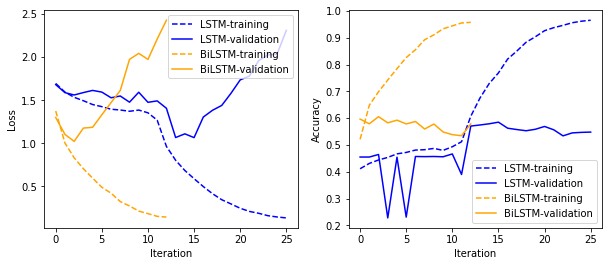

In [38]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

- Built our own Embedding

In [39]:
train_tokens_1 = [tokenize(text) for text in train_texts]
valid_tokens_1 = [tokenize(text) for text in valid_texts]
test_tokens_1 = [tokenize(text) for text in test_texts]

train_stemmed_1 = [stem(tokens) for tokens in train_tokens_1]
valid_stemmed_1 = [stem(tokens) for tokens in valid_tokens_1]
test_stemmed_1 = [stem(tokens) for tokens in test_tokens_1]

train_feats_1 = train_stemmed_1
valid_feats_1 = valid_stemmed_1
test_feats_1 = test_stemmed_1

In [40]:
f = open("review.txt","w")
for x in train_feats_1:
    for y in x:
        f.write(y)
        f.write(" ")
    f.write("\n")      
for a in valid_feats_1:
    for b in a:
        f.write(b)
        f.write(" ")
    f.write("\n")      
for c in test_feats_1:
    for d in c:
        f.write(d)
        f.write(" ")
    f.write("\n")   
f.close()

 ./fasttext skipgram -input review.txt -output model -dim 128 -minCount 3 -epoch 20

In [41]:
embedding_matrix_1 = np.zeros((len(feats_dict), 128), dtype=np.float32)
with open("model.vec", "r") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix_1[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 14035 word dimension: 128


In [42]:
embedding_matrix_1

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.039279,  0.19171 ,  0.15541 , ...,  0.071704,  0.062258,
         0.018505],
       ...,
       [-0.22374 ,  0.27493 , -0.19488 , ..., -0.35514 ,  0.42539 ,
        -0.10917 ],
       [-0.53849 ,  0.30492 , -0.2371  , ...,  0.35788 , -0.087121,
         0.10214 ],
       [ 0.24852 ,  0.44958 ,  0.31876 , ..., -0.11574 ,  0.084951,
         0.12094 ]], dtype=float32)

In [44]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=128, hidden_size=256, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional= True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix_1,
                  activation="relu",
                  batch_norm=True,
                  l2_reg=0.001, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
word2vec_bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

Epoch 00020: early stopping
2000/2000 [==============================] - 10s 5ms/step
training loss: 0.6622777763009071 training accuracy 0.7383000254631042
valid loss: 0.9696588009595871 valid accuracy 0.6345000267028809


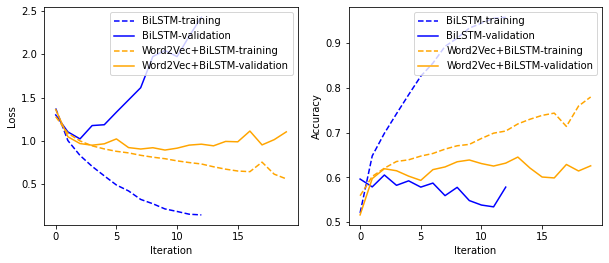

In [45]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["loss"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_loss"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="blue")
plt.plot(word2vec_bilstm_history.history["accuracy"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_accuracy"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Tryout_2, Google Word2Vec Embedding

- Import Wiki Embedding

In [7]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

In [8]:
train_no_punc_2 = [remove_punc(text) for text in train_texts]
train_tokens_2 = [tokenize(text) for text in train_no_punc_2]
train_no_stopword = [filter_stopwords(tokens) for tokens in train_tokens_2]

In [9]:
for token in train_no_stopword:
    for i in range(0,len(token)):
        token[i] = lemmatizer.lemmatize(token[i])

In [10]:
train_feats_2 = train_no_stopword

In [11]:
min_freq = 3
# build a mapping from features to indices
feats_dict_2 = get_feats_dict(
    chain.from_iterable(train_feats_2),
    min_freq=min_freq)

Size of features: 14726


In [12]:
valid_no_punc_2 = [remove_punc(text) for text in valid_texts]
valid_tokens_2 = [tokenize(text) for text in valid_no_punc_2]
valid_no_stopword = [filter_stopwords(tokens) for tokens in valid_tokens_2]

In [13]:
for token in valid_no_stopword:
    for i in range(0,len(token)):
        token[i] = lemmatizer.lemmatize(token[i])

In [14]:
valid_feats_2 = valid_no_stopword

In [15]:
test_no_punc_2 = [remove_punc(text) for text in test_texts]
test_tokens_2 = [tokenize(text) for text in test_no_punc_2]
test_no_stopword = [filter_stopwords(tokens) for tokens in test_tokens_2]

In [16]:
for token in test_no_stopword:
    for i in range(0,len(token)):
        token[i] = lemmatizer.lemmatize(token[i])

In [17]:
test_feats_2 = test_no_stopword

In [18]:
max_len = 150

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict_2, max_len) for f in train_feats_2])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict_2, max_len) for f in valid_feats_2])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict_2, max_len) for f in test_feats_2])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

In [19]:
from gensim.models.keyedvectors import KeyedVectors
gensim_model = KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin', binary=True, limit=3000000)

unable to import 'smart_open.gcs', disabling that module
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [20]:
embedding_matrix_2 = np.zeros((len(feats_dict_2), 300), dtype=np.float32)
for word in feats_dict_2:
    word_idx = feats_dict_2.get(word, -1)
    if word in gensim_model:
        embedding_matrix_2[word_idx] = np.array(gensim_model[word], dtype=np.float32)
    else:
        embedding_matrix_2[word_idx] = np.array(np.zeros(300), dtype=np.float32)

In [21]:
embedding_matrix_2

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.20703125,  0.203125  ,  0.04199219, ...,  0.13867188,
         0.03686523, -0.02868652],
       ...,
       [-0.31835938,  0.12597656, -0.17382812, ...,  0.00891113,
        -0.14648438,  0.55078125],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11572266,  0.26367188, -0.19628906, ..., -0.09033203,
        -0.09619141,  0.15429688]], dtype=float32)

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict_2),
                  embedding_size=300, hidden_size=256, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional= True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix_2,
                  activation="relu",
                  batch_norm=True,
                  l2_reg=0.001, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
word2vec_bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                                    validation_split=0.1,
                                    epochs=100, batch_size=100, verbose=0,
                                    callbacks=[checkpointer, earlystopping])
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

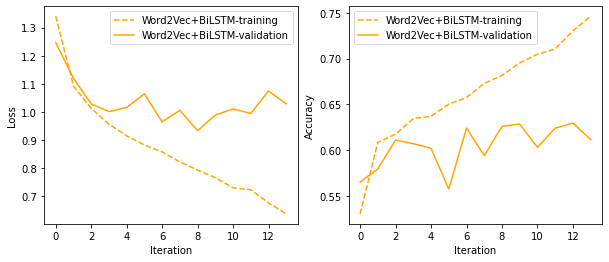

In [116]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(word2vec_bilstm_history.history["loss"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_loss"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(word2vec_bilstm_history.history["accuracy"], label="Word2Vec+BiLSTM-training", color="orange", linestyle="dashed")
plt.plot(word2vec_bilstm_history.history["val_accuracy"], label="Word2Vec+BiLSTM-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Final Prediction on Test Data

- Google News 300-d is a better one

In [117]:
# save predictions (Valid and Test Dataset)
valid_pred = model.predict(valid_feats_matrix) 
valid_pred=np.argmax(valid_pred,axis=1)
test_pred = model.predict(test_feats_matrix) 
test_pred=np.argmax(test_pred,axis=1)

for i in range(0,len(valid_pred)):
    valid_pred[i] = valid_pred[i]+1
for i in range(0,len(test_pred)):
    test_pred[i] = test_pred[i]+1

In [118]:
write_predictions('valid_pred.csv', valid_pred, valid_ids)
write_predictions('test_pred.csv', test_pred, test_ids)

In [100]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [119]:
ans = pd.read_csv("data/valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("data/valid_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.6475 	precision: 0.5452207599623294 	recall: 0.5311110738929457 	f1: 0.5226389273140538
